In [148]:
import torch
from torch import nn
from torch import optim

import pandas as pd
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [149]:
class CustomDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame, feature_names: list, target_name: str):
        scaler = StandardScaler()
        X = scaler.fit_transform(dataframe[feature_names])
        # X = dataframe[feature_names].values
        X = torch.tensor(X, dtype=torch.float32)
        
        self.X = X.reshape(X.shape[0], 1, X.shape[1])
        self.y = torch.tensor(dataframe[target_name].values, dtype=torch.float32)
        
    def __len__(self) -> int:
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [150]:
class FullyConnectedNet(nn.Module):

    def __init__(self, in_size: int, hidden_size: list, out_size: int):
        super(FullyConnectedNet, self).__init__()

        self.Network = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_size, hidden_size[0]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size[0]),

            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size[1]),

            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size[2]),

            nn.Linear(hidden_size[2], hidden_size[3]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size[3]),

            # nn.Linear(hidden_size[3], hidden_size[4]),
            # nn.ReLU(),
            # nn.BatchNorm1d(hidden_size[4]),

            # nn.Linear(hidden_size[4], hidden_size[5]),
            # nn.ReLU(),
            # nn.BatchNorm1d(hidden_size[5]),

            # nn.Linear(hidden_size[5], hidden_size[6]),
            # nn.ReLU(),
            # nn.BatchNorm1d(hidden_size[6]),

            nn.Linear(hidden_size[3], out_size),
        )
    
    def forward(self, x):
        return self.Network(x)


In [151]:
df = pd.read_csv("data\df_01.csv", index_col=[0])
df = df.reset_index().drop(columns=['index'])

In [152]:
lithology_keys = {30000: 0,
                  65030: 1,
                  65000: 2,
                  80000: 3,
                  74000: 4,
                  70000: 5,
                  70032: 6,
                  88000: 7,
                  86000: 8,
                  99000: 9,
                  90000: 10,
                  93000: 11}

In [153]:
df['FORCE_2020_LITHOFACIES_LITHOLOGY'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

In [154]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_ecoded = encoder.fit_transform(df[['FORCE_2020_LITHOFACIES_LITHOLOGY']])
one_hot_df = pd.DataFrame(one_hot_ecoded, columns=encoder.get_feature_names_out())
df = pd.concat([df, one_hot_df], axis=1)

In [155]:
feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RMED', 'RDEP', 'RHOB',
                 'GR', 'NPHI', 'PEF', 'DTC', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'ROPA'] 

target_name = ['FORCE_2020_LITHOFACIES_LITHOLOGY_0', 'FORCE_2020_LITHOFACIES_LITHOLOGY_1', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_2', 'FORCE_2020_LITHOFACIES_LITHOLOGY_3',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_4', 'FORCE_2020_LITHOFACIES_LITHOLOGY_5',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_6', 'FORCE_2020_LITHOFACIES_LITHOLOGY_7', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_8', 'FORCE_2020_LITHOFACIES_LITHOLOGY_9',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_10']

In [156]:
from sklearn.model_selection import train_test_split

train_, val = train_test_split(df, test_size=0.2, random_state=42,
                               shuffle=True, stratify=df.FORCE_2020_LITHOFACIES_LITHOLOGY)


In [157]:
train = CustomDataset(dataframe=train_, feature_names=feature_names, target_name=target_name)
val = CustomDataset(dataframe=val, feature_names=feature_names, target_name=target_name)

train, test = data.random_split(train, [0.8, 0.2])

In [158]:
train_data = DataLoader(dataset=train, batch_size=32, shuffle=True)
val_data = DataLoader(dataset=val, batch_size=32, shuffle=True)
test_data = DataLoader(dataset=test, batch_size=32, shuffle=False)

In [159]:
len(target_name)

11

In [160]:
model = FullyConnectedNet(in_size=len(feature_names), hidden_size=[288, 144, 72, 36], out_size=len(target_name))
print(model)

FullyConnectedNet(
  (Network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18, out_features=288, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=288, out_features=144, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=144, out_features=72, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=72, out_features=36, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Linear(in_features=36, out_features=11, bias=True)
  )
)


In [162]:
optimizer = optim.Adagrad(params=model.parameters(), lr=0.01) #, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

In [163]:
epochs = 50
best_loss = 1e10 # заведомо высокое значение
loss_val = []
loss_train = []

for e in range(epochs):
    model.train()
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=False)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f'Epoch [{e+1}/{epochs}], loss_mean={loss_mean:.3f} ')
    
    model.eval()
    Q_val = 0
    count_val = 0

    for x_val, y_val in val_data:
        with torch.no_grad():
            prediction = model(x_val)
            loss = loss_function(prediction, y_val)
            Q_val += loss.item()
            count_val += 1

    Q_val /= count_val

    loss_train.append(loss_mean)
    loss_val.append(Q_val)
    
    print(f' | loss_mean={loss_mean:.3f}, Q_val={Q_val:.3f}')




 | loss_mean=0.454, Q_val=0.345


 | loss_mean=0.337, Q_val=0.291


 | loss_mean=0.307, Q_val=0.270


 | loss_mean=0.293, Q_val=0.278


 | loss_mean=0.281, Q_val=0.268


 | loss_mean=0.273, Q_val=0.281


 | loss_mean=0.265, Q_val=0.267


 | loss_mean=0.258, Q_val=0.249


 | loss_mean=0.254, Q_val=0.251


 | loss_mean=0.250, Q_val=0.242


 | loss_mean=0.246, Q_val=0.238


 | loss_mean=0.246, Q_val=0.258


 | loss_mean=0.238, Q_val=0.240


 | loss_mean=0.238, Q_val=0.238


 | loss_mean=0.234, Q_val=0.237


 | loss_mean=0.235, Q_val=0.236


 | loss_mean=0.230, Q_val=0.227


 | loss_mean=0.226, Q_val=0.222


 | loss_mean=0.228, Q_val=0.227


 | loss_mean=0.225, Q_val=0.225


 | loss_mean=0.223, Q_val=0.222


 | loss_mean=0.223, Q_val=0.219


 | loss_mean=0.220, Q_val=0.215


 | loss_mean=0.219, Q_val=0.222


 | loss_mean=0.217, Q_val=0.218


 | loss_mean=0.216, Q_val=0.224


 | loss_mean=0.215, Q_val=0.213


 | loss_mean=0.215, Q_val=0.216


 | loss_mean=0.212, Q_val=0.228


 | loss_mean=0.211, Q_val=0.213


 | loss_mean=0.210, Q_val=0.215


 | loss_mean=0.207, Q_val=0.209


 | loss_mean=0.208, Q_val=0.221


 | loss_mean=0.208, Q_val=0.225


 | loss_mean=0.206, Q_val=0.216


 | loss_mean=0.205, Q_val=0.208


 | loss_mean=0.205, Q_val=0.213


 | loss_mean=0.202, Q_val=0.232


 | loss_mean=0.203, Q_val=0.208


 | loss_mean=0.198, Q_val=0.213


 | loss_mean=0.200, Q_val=0.205


 | loss_mean=0.200, Q_val=0.207


 | loss_mean=0.199, Q_val=0.224


 | loss_mean=0.199, Q_val=0.206


 | loss_mean=0.198, Q_val=0.200


 | loss_mean=0.197, Q_val=0.210


 | loss_mean=0.196, Q_val=0.201


 | loss_mean=0.196, Q_val=0.207


 | loss_mean=0.195, Q_val=0.210


 | loss_mean=0.196, Q_val=0.208


In [164]:
Q = 0

In [165]:
model.eval()

FullyConnectedNet(
  (Network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18, out_features=288, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=288, out_features=144, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=144, out_features=72, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=72, out_features=36, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Linear(in_features=36, out_features=11, bias=True)
  )
)

In [166]:
predictions = []
tests = []
test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    predict = model(x_test)
    predict = torch.argmax(predict, dim=1)
    y_test = torch.argmax(y_test, dim=1)
    predictions.extend(predict.cpu().detach().numpy().tolist())
    tests.extend(y_test.cpu().detach().numpy().tolist())
    Q += torch.sum(predict == y_test).item()

100%|██████████| 608/608 [00:02<00:00, 227.37it/s]


In [167]:
Q /= len(test_data)
print(Q)

29.73355263157895


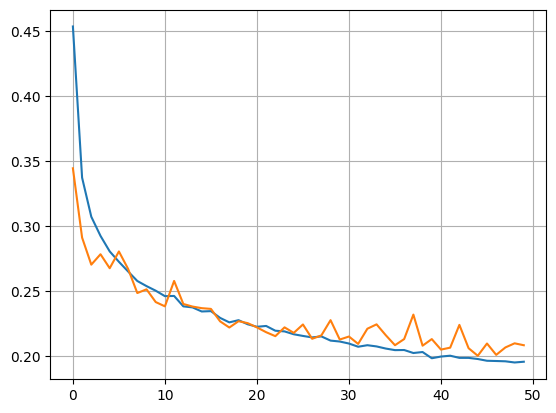

In [168]:
plt.plot(loss_train)
plt.plot(loss_val)
plt.grid()
plt.show()

In [169]:
from sklearn.metrics import confusion_matrix, classification_report

In [170]:
print(classification_report(tests, predictions))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2400
           1       0.80      0.80      0.80      1643
           2       0.96      0.96      0.96     11094
           3       0.86      0.89      0.88       856
           4       0.74      0.40      0.52        42
           5       0.90      0.84      0.87      1389
           6       0.96      0.98      0.97       469
           7       0.99      0.99      0.99      1018
           8       0.89      0.80      0.84       105
           9       0.89      0.92      0.91       379
          10       0.62      0.94      0.75        32

    accuracy                           0.93     19427
   macro avg       0.87      0.86      0.85     19427
weighted avg       0.93      0.93      0.93     19427



<Axes: >

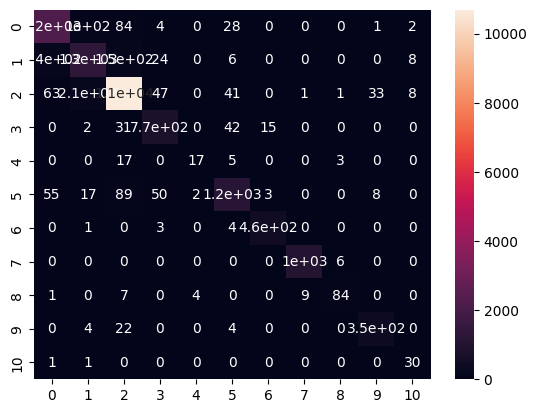

In [171]:
cm = confusion_matrix(tests, predictions)
sns.heatmap(cm, annot=True)

In [ ]:
torch.save(model.state_dict(), 'models/fully_connected.tar')

In [ ]:
model_2 = FullyConnectedNet(in_size=len(feature_names), hidden_size=[576, 435, 288, 144, 72, 36], out_size=len(target_name))
state_dict = torch.load('models/fully_connected.tar', weights_only=True)
model_2.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for FullyConnectedNet:
	size mismatch for Network.1.weight: copying a param with shape torch.Size([288, 15]) from checkpoint, the shape in current model is torch.Size([576, 15]).
	size mismatch for Network.1.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for Network.3.weight: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for Network.3.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for Network.3.running_mean: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for Network.3.running_var: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([576]).
	size mismatch for Network.4.weight: copying a param with shape torch.Size([144, 288]) from checkpoint, the shape in current model is torch.Size([435, 576]).
	size mismatch for Network.4.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([435]).
	size mismatch for Network.6.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([435]).
	size mismatch for Network.6.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([435]).
	size mismatch for Network.6.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([435]).
	size mismatch for Network.6.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([435]).
	size mismatch for Network.7.weight: copying a param with shape torch.Size([72, 144]) from checkpoint, the shape in current model is torch.Size([288, 435]).
	size mismatch for Network.7.bias: copying a param with shape torch.Size([72]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for Network.9.weight: copying a param with shape torch.Size([72]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for Network.9.bias: copying a param with shape torch.Size([72]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for Network.9.running_mean: copying a param with shape torch.Size([72]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for Network.9.running_var: copying a param with shape torch.Size([72]) from checkpoint, the shape in current model is torch.Size([288]).
	size mismatch for Network.10.weight: copying a param with shape torch.Size([36, 72]) from checkpoint, the shape in current model is torch.Size([144, 288]).
	size mismatch for Network.10.bias: copying a param with shape torch.Size([36]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for Network.12.weight: copying a param with shape torch.Size([36]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for Network.12.bias: copying a param with shape torch.Size([36]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for Network.12.running_mean: copying a param with shape torch.Size([36]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for Network.12.running_var: copying a param with shape torch.Size([36]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for Network.13.weight: copying a param with shape torch.Size([11, 36]) from checkpoint, the shape in current model is torch.Size([11, 144]).